## RT Plan and dose calculation

In [8]:
import os
import matplotlib.pyplot as plt
from opentps.core.data.plan._rtPlan import RTPlan
from opentps.core.io.scannerReader import readScanner
from opentps.core.io.serializedObjectIO import loadRTPlan, saveRTPlan
from opentps.core.io.dicomIO import readDicomPlan
from opentps.core.io.dataLoader import readData
from opentps.core.data.CTCalibrations.MCsquareCalibration._mcsquareCTCalibration import MCsquareCTCalibration
from opentps.core.io import mcsquareIO
from opentps.core.data._dvh import DVH
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.io.mhdIO import exportImageMHD
from opentps.core.data.plan._planIonBeam import PlanIonBeam
from opentps.core.data.plan._planIonLayer import PlanIonLayer
from opentps.core.data.images._ctImage import CTImage
from opentps.core.data._rtStruct import RTStruct

### Create plan from scratch

In [9]:
plan = RTPlan()
plan.appendBeam(PlanIonBeam())
plan.appendBeam(PlanIonBeam())
plan.beams[1].gantryAngle = 120.
plan.beams[0].appendLayer(PlanIonLayer(100))
plan.beams[0].appendLayer(PlanIonLayer(90))
plan.beams[1].appendLayer(PlanIonLayer(80))
plan[0].layers[0].appendSpot([-1,0,1], [1,2,3], [0.1,0.2,0.3])
plan[0].layers[1].appendSpot([0,1], [2,3], [0.2,0.3])
plan[1].layers[0].appendSpot(1, 1, 0.5)
# Save plan
saveRTPlan(plan,'test_plan.tps')

Load plan in OpenTPS format (serialized)

In [10]:
plan2 = loadRTPlan('test_plan.tps')
print(plan2[0].layers[1].spotWeights)
print(plan[0].layers[1].spotWeights)
plan_path = r"/home/romain/dataset_testing/BREAST_01_003/BH/RTPLAN.237435.dcm"
plan3 = readDicomPlan(plan_path)

[0.2 0.3]
[0.2 0.3]
ERROR: Conventional radiotherapy (photon) plans are not supported


### Dose computation from plan

choosing default scanner and BDL

In [11]:
doseCalculator = MCsquareDoseCalculator()
doseCalculator.ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
doseCalculator.beamModel = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)
doseCalculator.nbPrimaries = 1e7
ctImagePath = r'/home/romain/dataset_testing/BREAST_01_003/BH'
dataList = readData(ctImagePath, maxDepth=0)
ct = [d for d in dataList if isinstance(d, CTImage)][0]
struct = [d for d in dataList if isinstance(d, RTStruct)][0]

/home/romain/dataset_testing/BREAST_01_003/BH/CT.101202.dcm
/home/romain/dataset_testing/BREAST_01_003
/home/romain/dataset_testing/BREAST_01_003/BH/CT.115929.dcm
/home/romain/dataset_testing/BREAST_01_003
/home/romain/dataset_testing/BREAST_01_003/BH/CT.116979.dcm
/home/romain/dataset_testing/BREAST_01_003
/home/romain/dataset_testing/BREAST_01_003/BH/CT.120457.dcm
/home/romain/dataset_testing/BREAST_01_003
/home/romain/dataset_testing/BREAST_01_003/BH/CT.132898.dcm
/home/romain/dataset_testing/BREAST_01_003
/home/romain/dataset_testing/BREAST_01_003/BH/CT.142838.dcm
/home/romain/dataset_testing/BREAST_01_003
/home/romain/dataset_testing/BREAST_01_003/BH/CT.146044.dcm
/home/romain/dataset_testing/BREAST_01_003
/home/romain/dataset_testing/BREAST_01_003/BH/CT.153029.dcm
/home/romain/dataset_testing/BREAST_01_003
/home/romain/dataset_testing/BREAST_01_003/BH/CT.158568.dcm
/home/romain/dataset_testing/BREAST_01_003
/home/romain/dataset_testing/BREAST_01_003/BH/CT.163110.dcm
/home/romain/

--- Logging error ---
Traceback (most recent call last):
  File "/home/romain/miniconda3/envs/OpenTPS/lib/python3.11/logging/__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/home/romain/miniconda3/envs/OpenTPS/lib/python3.11/logging/__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/home/romain/miniconda3/envs/OpenTPS/lib/python3.11/logging/__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/home/romain/miniconda3/envs/OpenTPS/lib/python3.11/logging/__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/romain/miniconda3/envs/OpenTPS/lib/python3.11/site-packages/ipykernel_launcher.py",

If we want to crop the CT to the body contour (set everything else to -1024)

In [12]:
contour_name = 'patient salade'
struct.print_ROINames()
body_contour = struct.getContourByName(contour_name)
doseCalculator.overwriteOutsideROI = body_contour[0]


RT Struct UID: 1.2.752.243.1.1.20200901124047710.1900.27273.1
  [0]  patient
  [1]  A_Coronary
  [2]  Heart
  [3]  lung_L
  [4]  lung_R
  [5]  CTVp_breast L
  [6]  SpinalCord
  [7]  HumeralHead_L
  [8]  CTVp_tumourbed L
  [9]  Lungs
  [10]  PTVp_Breast_L
  [11]  PTV_boost_L
  [12]  Stomach
  [13]  Breast_R
  [14]  ETV_Robust
  [15]  External
  [16]  Carbon Fiber
  [17]  bloc deform
  [18]  105
  [19]  min
  [20]  ROI_4575.0_1
  [21]  95
  [22]  ref
  [23]  ISO
  [24]  DSP
  [25]  DSP45.75
  [26]  POI_4575.0_1
No contour with name salade found in the list of contours


MC square simulation and Dose exportation

In [13]:
doseImage = doseCalculator.computeDose(ct, plan)
exportImageMHD(r'/home/romain/doseCal', doseImage)

07/08/2023 06:10:23 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Dose calculation
07/08/2023 06:10:23 PM - opentps.core.io.mcsquareIO - INFO - Cropping CT around patient
07/08/2023 06:10:24 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/romain/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
07/08/2023 06:10:24 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/romain/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
07/08/2023 06:10:25 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.685358 s 


Simulation started (2023-08-07 18:10:25) 
 10.0 % 
 20.0 % 
 30.0 % 
 40.0 % 
 50.0 % (stat uncertainty: 0.37 %) 
 60.0 % (stat uncertainty: 0.35 %) 
 70.0 % (stat uncertainty: 0.34 %) 
 80.0 % (stat uncertainty: 0.32 %) 
 90.0 % (stat uncertainty: 0.31 %) 
 100.0 % (stat uncertainty: 0.29 %) 

Nbr primaries simulated: 10000000 
MC computation time: 90.900472 s 
Output computation time: 0.107685 s 

Total computation time: 91.709478 s 
07/08/2023 06:11:57 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/romain/doseCal.mhd


DVH

D95 0.03662109375
D5 0.03662109375
Dmax 0.00012169612
Dmin 0.0


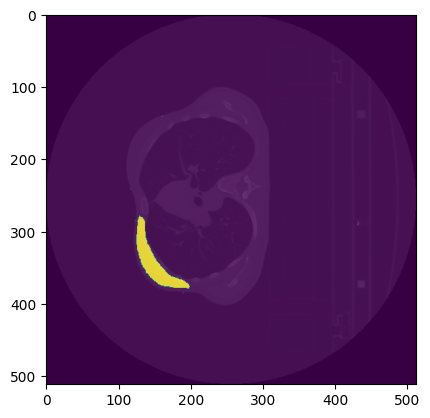

In [25]:
target_name = 'PTVp_Breast_L'
target_contour = struct.getContourByName(target_name)
print(target_contour)
dvh = DVH(target_contour[0], doseImage)
print("D95",dvh._D95)
print("D5",dvh._D5)
print("Dmax",dvh._Dmax)
print("Dmin",dvh._Dmin)
sliceLoc = 50
plt.imshow(ct.imageArray[:,:,sliceLoc],cmap='gray')
plt.imshow(target_contour[0].getBinaryMask(origin= ct.origin,gridSize= ct.gridSize,spacing=ct.spacing).imageArray[:,:,sliceLoc],alpha =.8)